In [49]:
import pandas as pd
import numpy as np

# Word Embeddings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
print(f'gensim: {gensim.__version__}')

# Doc2Vec
from nltk.tokenize import word_tokenize 
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

# Storing as objects via serialization
from tempfile import mkdtemp
import pickle
import joblib

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Directory
import os
import yaml

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

# Getting the viz package I wrote
from viz import top10_bagofwords
# import viz

## LOADING OBJECTS
processed_inbound = pd.read_pickle('objects/processed_inbound.pkl')

# Reading back in intents
with open(r'objects/intents.yml') as file:
    intents = yaml.load(file, Loader=yaml.FullLoader)

# We start with this data, here's the preview
print(processed_inbound.head())
print(f'\nintents:\n{intents}')
# Loading in the Doc2Vec model and data
model = Doc2Vec.load("models/d2v.model")
inbound_d2v = pd.read_pickle('objects/inbound_d2v.pkl')

gensim: 3.8.0


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


0     [new, update, i️, make, sure, download, yester...
4     [hey, anyone, else, upgraded, io, issue, capit...
9     [hello, internet, someone, explain, symbol, ke...
10    [get, screenshot, say, iphonex, reserve, email...
12    [thank, update, phone, even, slow, barely, wor...
dtype: object

intents:
{'app': ['app', 'application'], 'battery': ['battery'], 'bug': ['bug'], 'greeting': ['hi', 'hello', 'hey', 'yo'], 'icloud': ['icloud', 'i cloud'], 'ios': ['io'], 'iphone': ['iphone', 'i phone'], 'mac': ['mac', 'macbook', 'laptop', 'computer'], 'music': ['music', 'song', 'playlist'], 'payment': ['credit', 'card', 'payment', 'pay'], 'settings': ['settings', 'setting'], 'troubleshooting': ['problem', 'trouble'], 'update': ['update'], 'watch': ['watch']}


# Tweet Collection with Doc2Vec
I can use my Doc2Vec representation to find top 1000 Tweets most similar to a generalized intent version of a Tweet based on it's cosine similarity. 

Heuristic search refers to a search strategy that attempts to optimize a problem by iteratively improving the solution based on a given heuristic function or a cost measure. My cost measure is trying to get the closest cosine distances.

This is really cool. So I basically trained my doc2vec model with my training data, which is the processed_inbound. I can actually compute a vector based on my training data to vectorize that word.

I have two ways of getting my base representative tweet that my 1000 Tweets will be similar to. The first is to make this representative Tweet myself - trying to find an idealized, wholistic representation of one tweet. Then from there I use my doc2vec representations to find the top 1000 tweets most similar based on cosine similarity The second is to use existing data that I feel is pretty representative of what an intent embodies and doing the same thing.

### Approach 1 - Based on inferring my own ideal representation of an intent

In [44]:
# This is a method that could vectorize a Tweet using inference
# to find the vector of a document which is not in training data!
# Just put it in here for reference.
model.infer_vector(['please', 'help', 'me'])

array([ 0.03888087, -0.1374864 , -0.13460197,  0.04150333, -0.02994516,
       -0.1107936 , -0.0732221 , -0.10364282, -0.08071923,  0.14078899,
        0.189926  ,  0.02725885,  0.08827287,  0.00035473,  0.10687265,
       -0.01234037, -0.08911869, -0.00721097, -0.10153838,  0.01915126],
      dtype=float32)

In [46]:
# Finding and making idealized versions of each intent so that I can find top 1000 to it:
intents_ideal = {'app': ['app', 'prob']}
inferred_vectors = []

for keywords in intents_ideal.values():
    inferred_vectors.append(model.infer_vector(keywords))
    
inferred_vectors

[array([ 0.03898046, -0.06594096, -0.01952571, -0.05561247, -0.04156677,
        -0.14806812,  0.00154858, -0.11804407,  0.11642253,  0.12098304,
         0.15545522, -0.00788148,  0.10425902,  0.04159037,  0.03344142,
        -0.01507425, -0.20064837, -0.05765211, -0.00772596,  0.13033028],
       dtype=float32)]

In [29]:
# model.similarity(inferred_vectors[0], inbound_d2v[0])

### Approach 2 - Getting representation Tweet using training data

In [51]:
intents

{'app': ['app', 'application'],
 'battery': ['battery'],
 'bug': ['bug'],
 'greeting': ['hi', 'hello', 'hey', 'yo'],
 'icloud': ['icloud', 'i cloud'],
 'ios': ['io'],
 'iphone': ['iphone', 'i phone'],
 'mac': ['mac', 'macbook', 'laptop', 'computer'],
 'music': ['music', 'song', 'playlist'],
 'payment': ['credit', 'card', 'payment', 'pay'],
 'settings': ['settings', 'setting'],
 'troubleshooting': ['problem', 'trouble'],
 'update': ['update'],
 'watch': ['watch']}

In [170]:
# Storing my representative tweets and intents in this dictionary
# Just need to add to this dictionary and the rest of the code block does the work for you
# To find a suitable representative tweet for this: I used the keyword EDA functions in notebook 1.1
intents_repr = {'Battery': ['io', 'drain', 'battery', 'iphone', 'twice', 'fast', 'io', 'help'],
    'Update': ['new', 'update', 'i️', 'make', 'sure', 'download', 'yesterday'],
    'iphone': ['instal', 'io', 'make', 'iphone', 'slow', 'work', 'properly', 'help'],
    'app': ['app', 'still', 'longer', 'able', 'control', 'lockscreen'],
    'mac': ['help','mac','app','store','open','can','not','update','macbook','pro','currently','run','o','x',
  'yosemite']
    }

# Storing tags in order of the dictionary above
tags = []

# Find the index locations of specific Tweets
def report_index_loc(tweet, intent_name):
    ''' Takes in the Tweet to find the index for and returns a report of that Tweet index along with what the 
    representative Tweet looks like'''
    tweets = []
    for i,j in enumerate(processed_inbound):
        if j == tweet:
            tweets.append((i, True))
        else:
            tweets.append((i, False))
    index = []
    get_index = [index.append(i[0]) if i[1] == True else False for i in tweets] # Comprehension saves space
    preview = processed_inbound.iloc[index[0]]
    # Appending to indexes for dictionary
    tags.append(str(index[0]))
    return intent_name, str(index[0]), preview

# Reporting and storing indexes with the function
print('TAGGED INDEXES TO LOOK FOR')
for j,i in intents_repr.items():
    print('\n{} \nIndex: {}\nPreview: {}'.format(*report_index_loc(i,j)))


# Pythonic way of making new dictionary from 2 lists
intents_tags = dict(zip(intents_repr.keys(), tags))
intents_tags

TAGGED INDEXES TO LOOK FOR

Battery 
Index: 204
Preview: ['io', 'drain', 'battery', 'iphone', 'twice', 'fast', 'io', 'help']

Update 
Index: 0
Preview: ['new', 'update', 'i️', 'make', 'sure', 'download', 'yesterday']

iphone 
Index: 71
Preview: ['instal', 'io', 'make', 'iphone', 'slow', 'work', 'properly', 'help']

app 
Index: 8
Preview: ['app', 'still', 'longer', 'able', 'control', 'lockscreen']

mac 
Index: 243
Preview: ['help', 'mac', 'app', 'store', 'open', 'can', 'not', 'update', 'macbook', 'pro', 'currently', 'run', 'o', 'x', 'yosemite']


{'Battery': '204', 'Update': '0', 'iphone': '71', 'app': '8', 'mac': '243'}

In [232]:
## Getting top n tweets similar to the 0th Tweet
# This will return the a list of tuples (i,j) where i is the index and j is 
# the cosine similarity to the tagged document index

# Storing all intents in this dataframe
train = pd.DataFrame()

def add_intent(intent_name, itag):
    similar_doc = model.docvecs.most_similar(itag,topn = 1000)
    # Getting just the indexes
    indexes = [int(i[0]) for i in similar_doc]
    # Actually seeing the top 1000 Tweets similar to the 0th Tweet which seems to be about updates
    # Adding just the values, not the index
    train[intent_name] = processed_inbound.iloc[indexes].values
    
for intent_name,itag in intents_tags.items():
    add_intent(intent_name, itag)
    
# Converting to long dataframe from wide that my NN model can read in for the next notebook - and wrangling
neat_train = pd.DataFrame(train.T.unstack()).reset_index().iloc[:,1:].rename(columns={'level_1':'Intent', 0: 'Utterance'})
# Reordering
neat_train = neat_train[['Utterance','Intent']]

# Saving this raw training data into a serialized file
neat_train.to_pickle('objects/train.pkl')

# Styling display
show = lambda x: x.head(10).style.set_properties(**{'background-color': 'black',                                                   
                                    'color': 'lawngreen',                       
                                    'border-color': 'white'})\
.applymap(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'red'}")\
.background_gradient(cmap='Blues')

show(train)

,Battery,Update,iphone,app,mac
0,"['hey', 'please', 'fix', 'io', 'battery', 'drain', 'issue', 'charge', 'several', 'time', 'day', 'ok']","['okay', 'new', 'update', 'io', 'still', 'see', 'question', 'mark', 'people', 'type', 'pleasefixthis']","['iphone', 'slow', 'dial', 'since', 'new', 'io', 'update']","['also', 'anytime', 'wan', 'na', 'fix', 'i️', 'thing', 'annnyyy', 'time']","['hi', 'instal', 'high', 'update', 'day', 'ago', 'start', 'morning', 'open', 'mail', 'page', 'itunes', 'update', 'iphone', 'froze', 'beachball', 'present', 'strange', 'screenshot', 'skeleton', 'desktop', 'turn', 'reboot', 'several', 'time', 'go', 'back', 'frozen']"
1,"['hey', 'fix', 'battery', 'issue', 'please', 'phone', 'dy', 'twice', 'fast', 'update']","['oh', 'nooo', 'baby', 'see', 'finna', 'i️', 'update', 'phone', 'sudden', 'autocorrect', 'wan', 'na', 'start', 'act', 'fix', 'like', 'yesterday', '😤']","['iphone', 'connect', 'wifi', 'anymore', 'since', 'io']","['i️', 'autocorrect', 'issue', 'i️', 'emoji', 'never', 'use', 'show', 'frequently', 'use']","['load', 'mac', 'update', 'apple', 'store', 'idea', 'please']"
2,"['download', 'late', 'software', 'update', 'iphone', 'battery', 'drain', 'twice', 'quickly', 'use']","['yo', 'one', 'get', 'weird', 'autocorrecting', 'i️', 'thing', 'download', 'new', 'update', 'still', 'happen']","['iphone', 'io', 'brave', 'upgrade', 'becuse', 'io', 'iphone', 'slow', 'slow', 'upgraded']","['instagram', 'back', 'button', 'lyft', 'close', 'button', 'twitter', 'back', 'button', 'profile', 'regular', 'issue']","['constant', 'lockup', 'restarts', 'since', 'upgrade', 'high', 'sierra', 'late', 'mbp']"
3,"['update', 'io', 'battery', 'start', 'drain', 'quickly', 'please', 'help']","['hi', 'ever', 'since', 'download', 'last', 'software', 'update', 'phone', 'freeze', 'play', 'know', 'issue', 'thanks']","['phone', 'new', 'download', 'io', 'update', 'phone', 'function', 'properly', 'ever', 'since']","['turn', 'app', 'notification', 'able', 'use', 'iphone', 'properly']","['macbook', 'pro', 'instal', 'high', 'sierra', 'update', 'hour', 'stucking', 'screen', 'help']"
4,"['new', 'io', 'update', 'new', 'battery', 'issue', 'unplugged', 'ten', 'min', 'already']","['can', 'not', 'install', 'new', 'apps', 'update', 'instal', 'one', ""'s""]","['iphone', 'jacked', 'ever', 'since', 'update', 'new', 'io', 'update', 'really', 'compatible', 'old', 'model']","['manually', 'adjust', 'outdoors', 'would', 'automatically', 'also', 'never', 'put', 'high', 'indoor', 'use']","['hi', 'update', 'mbp', 'install', 'need', 'whats', 'longer', 'aviable', 'app', 'store', 'solution']"
5,"['currently', 'run', 'iphone', 'plus', 'issue', 'battery', 'io', 'update']","['i️', 'i️', 'update', 'today', 'like', 'idk', 'happen']","['iphone', 'slow', 'since', 'update', 'software', 'moggywheel']","['volume', 'get', 'adjust', 'constantly', 'listen', 'music', 'without', 'earpods', 'even', 'listen', 'anything', 'use', 'io', 'problem', 'previous', 'version', 'io']","['upgraded', 'macbook', 'pro', 'touchbar', 'mac', 'reboots', 'message', 'touch', 'bar', 'work']"
6,"['could', 'drain', 'beer', 'quickly', 'io', 'update', 'drain', 'battery']","['i', 'would', 'say', 'last', 'week', 'happen', 'twice', 'yesterday', 'today', 'fine', 'odd', 'install', 'late', 'update', 'last', 'night']","['iphone', 'work', 'properly', 'since', 'io', 'update']","['annoy', 'i️', 'look', 'ton', 'people', 'problem', 'apple', 'even', 'address']","['get', 'instal', 'high', 'sierra', 'dot', 'update', 'mac', 'app', 'store']"
7,"['battery', 'minute', 'later', 'io', 'fix', 'please']","['sure', 'iphonexpreorder', 'go', 'gotten', 'email', 'order', 'history', 'show', 'anything', 'nervous']","['upgraded', 'late', 'o', 'connect', 'home', 'wifi', 'network', 'anymore']","['app', 'also', 'crash', 'constantly', 'try', 're-download', 'previously', 'played', 'podcasts', 'also', 'auto', 'play']","['ibooks', 'macbook', 'can', 'not', 'open', 'book']"
8,"['wrong', 'update', 'face', 'battery', 'issue', 'update', 'phone', 'charge', 'ph

I feel like the quality is lacking if I do not create my idealized versions of an intent, but they're pretty good.

In [230]:
show(neat_train)

,Utterance,Intent
0,"['hey', 'please', 'fix', 'io', 'battery', 'drain', 'issue', 'charge', 'several', 'time', 'day', 'ok']",Battery
1,"['okay', 'new', 'update', 'io', 'still', 'see', 'question', 'mark', 'people', 'type', 'pleasefixthis']",Update
2,"['iphone', 'slow', 'dial', 'since', 'new', 'io', 'update']",iphone
3,"['also', 'anytime', 'wan', 'na', 'fix', 'i️', 'thing', 'annnyyy', 'time']",app
4,"['hi', 'instal', 'high', 'update', 'day', 'ago', 'start', 'morning', 'open', 'mail', 'page', 'itunes', 'update', 'iphone', 'froze', 'beachball', 'present', 'strange', 'screenshot', 'skeleton', 'desktop', 'turn', 'reboot', 'several', 'time', 'go', 'back', 'frozen']",mac
5,"['hey', 'fix', 'battery', 'issue', 'please', 'phone', 'dy', 'twice', 'fast', 'update']",Battery
6,"['oh', 'nooo', 'baby', 'see', 'finna', 'i️', 'update', 'phone', 'sudden', 'autocorrect', 'wan', 'na', 'start', 'act', 'fix', 'like', 'yesterday', '😤']",Update
7,"['iphone', 'connect', 'wifi', 'anymore', 'since', 'io']",iphone
8,"['i️', 'autocorrect', 'issue', 'i️', 'emoji', 'never', 'use', 'show', 'frequently', 'use']",app
9,"['load', 'mac', 'update', 'apple', 'store', 'idea', 'please']",mac


These all actually look really promising as they all seem to have some relation to their respective buckets. An emoji escaped from my preprocessing function, but they are not so few in quantity that I feel like I don't need to remove it for now, they are just noise.

# Intent Bucket Evaluation

In [176]:
# Storing word rank table dataframes in this dict
wordranks = {}

# For visualizing top 10
def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    # Output will be a sparse matrix
    inbound = bagofwords.fit_transform(data)
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    wordranks[output_name] = words_rank
    # words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself
    # Visualizing top 10 words
    plt.figure(figsize=(12,6))
    sns.barplot(words_rank['word'][:10], words_rank['count'][:10].astype(str), palette = 'inferno')
    plt.title(title)
    
    # Saving
    plt.savefig(f'visualizations/{output_name}.png')
    
    plt.show()

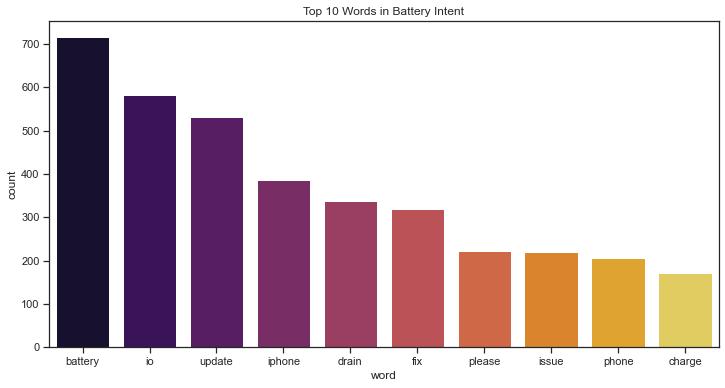

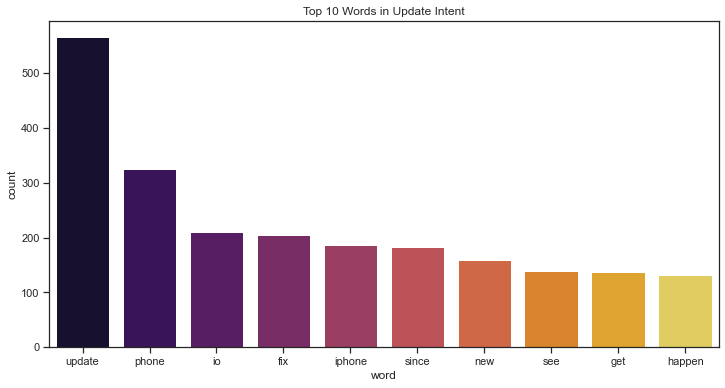

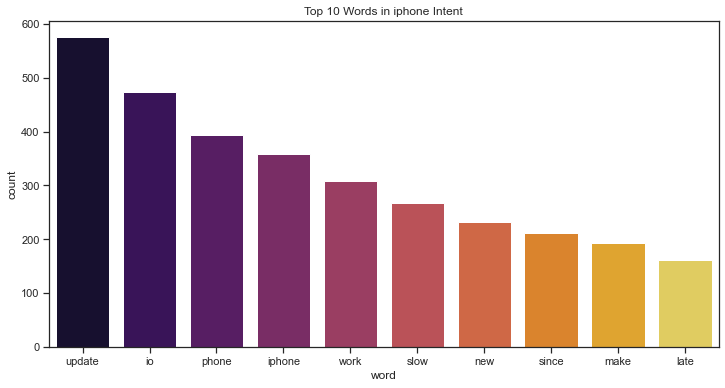

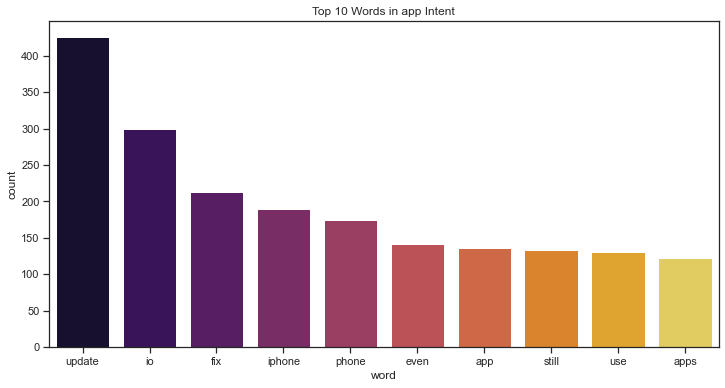

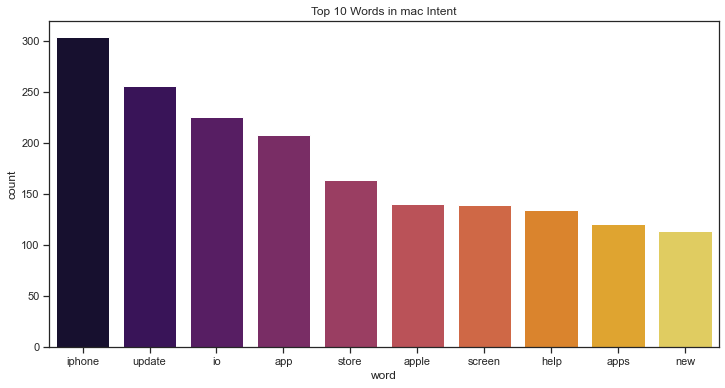

In [177]:
# Doing my bucket evaluations here - seeing what each distinct bucket intent means
for i in intents_repr.keys():
    top10_bagofwords(train[i].apply(" ".join), f'bucket_eval/{i}', f'Top 10 Words in {i} Intent')

In [183]:
# Investigating bag of word frequencies at a more granular level
wordranks['bucket_eval/mac'].head(50)

,word,count
849,iphone,304
1777,update,256
841,io,225
79,app,208
1614,store,164
84,apple,140
1459,screen,139
729,help,134
95,apps,121
1073,new,114


Without emojis:

[('72326', 0.8154675364494324),
 ('32166', 0.8151031732559204),
 ('29461', 0.8027088642120361),
 ('5942', 0.7968393564224243),
 ('54836', 0.7879305481910706),
 ('30359', 0.7861931324005127),
 ('66201', 0.7817540168762207),
 ('50109', 0.7796376943588257),
 ('59490', 0.7793254852294922),
 ('46644', 0.7775745391845703),
 ('58410', 0.7734568119049072),
 ('26164', 0.7674931287765503),
 ('14867', 0.7673683166503906),
 ('25813', 0.766610860824585),
 ('47880', 0.7642890214920044),
 ('30945', 0.76273113489151),
 ('74155', 0.7582229971885681),
 ('33346', 0.7577282190322876),
 ('9502', 0.7569847702980042),
 ('64871', 0.7567278146743774)

# Fine tuning my training data